## RAJASIMHA CS23B1013


In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
DATASET_PATH = "DATASET3"

In [7]:
def load_sample(sample_path):

    img_folder = os.path.join(sample_path,"images")
    img_name = os.listdir(img_folder)[0]
    image = cv2.imread(os.path.join(img_folder,img_name))

    mask_folder = os.path.join(sample_path,"masks")
    combined = None

    for m in os.listdir(mask_folder):
        mask=cv2.imread(os.path.join(mask_folder,m),0)
        mask=(mask>0).astype(np.uint8)
        combined = mask if combined is None else np.maximum(combined,mask)

    return image,combined

In [ ]:
def watershed_without_markers(image):

    gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    blur=cv2.GaussianBlur(gray,(5,5),0)

    _,th=cv2.threshold(blur,0,255,
                       cv2.THRESH_BINARY+cv2.THRESH_OTSU)

   
    _,markers=cv2.connectedComponents(th)
    markers=markers+1

    markers=cv2.watershed(image,markers)

    res=image.copy()
    res[markers==-1]=[255,0,0]

    binary=np.zeros(markers.shape,np.uint8)
    binary[markers>1]=1

    return res,binary

In [12]:
def watershed_with_markers(image):

    gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    blur=cv2.GaussianBlur(gray,(5,5),0)

    _,th=cv2.threshold(blur,0,255,
                       cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    kernel=np.ones((3,3),np.uint8)

    sure_bg=cv2.dilate(th,kernel,3)

    dist=cv2.distanceTransform(th,cv2.DIST_L2,5)
    _,sure_fg=cv2.threshold(dist,0.4*dist.max(),255,0)
    sure_fg=np.uint8(sure_fg)

    unknown=cv2.subtract(sure_bg,sure_fg)

    _,markers=cv2.connectedComponents(sure_fg)
    markers=markers+1
    markers[unknown==255]=0

    markers=cv2.watershed(image,markers)

    res=image.copy()
    res[markers==-1]=[255,0,0]

    binary=np.zeros(markers.shape,np.uint8)
    binary[markers>1]=1

    return res,binary

In [13]:
def dice(pred,gt):
    inter=np.sum(pred*gt)
    return (2*inter)/(np.sum(pred)+np.sum(gt)+1e-6)

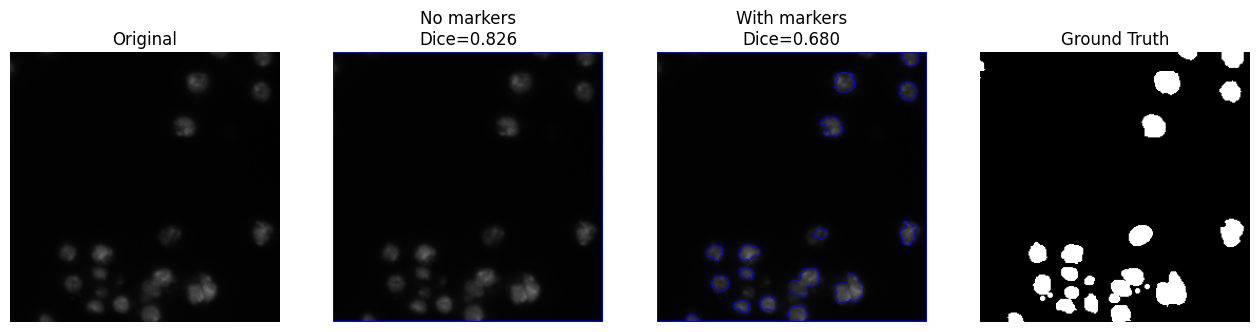

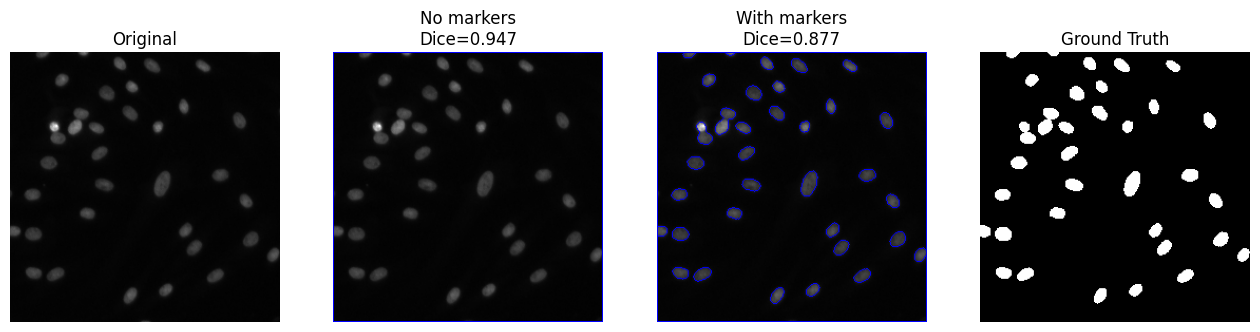

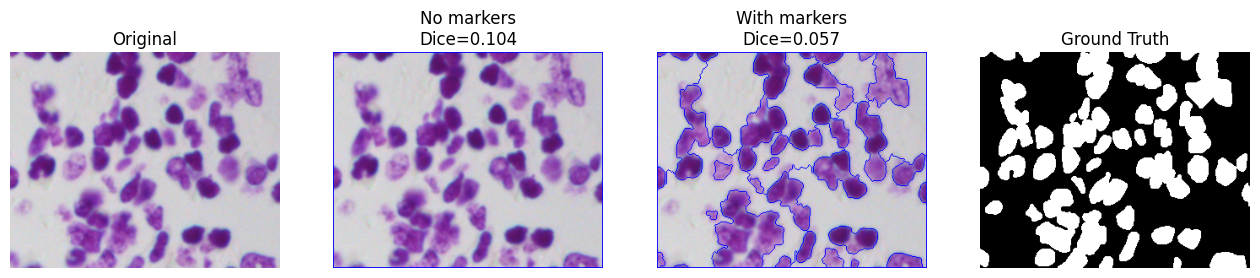

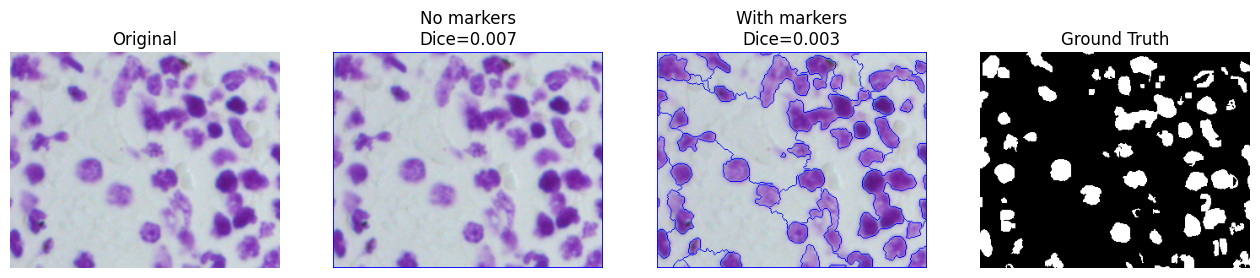

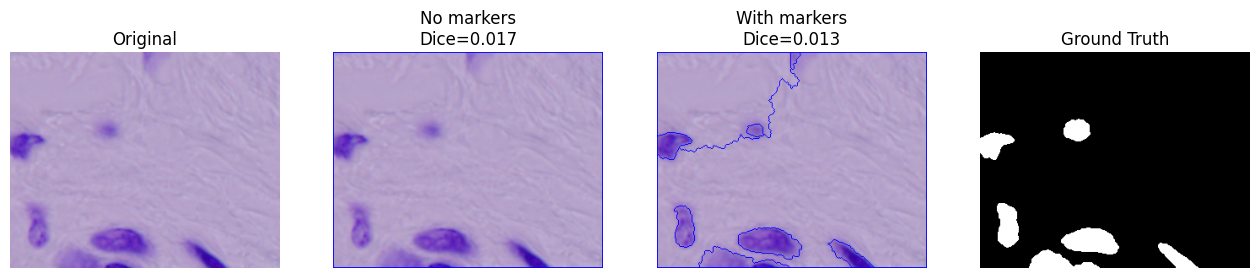

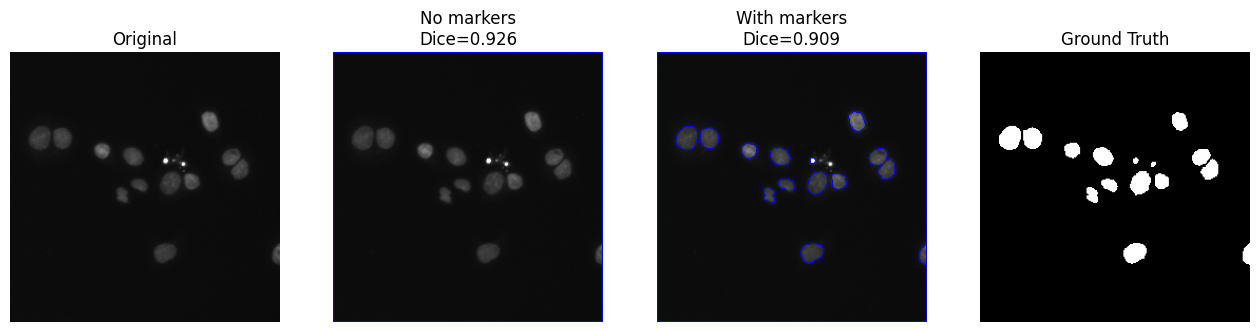

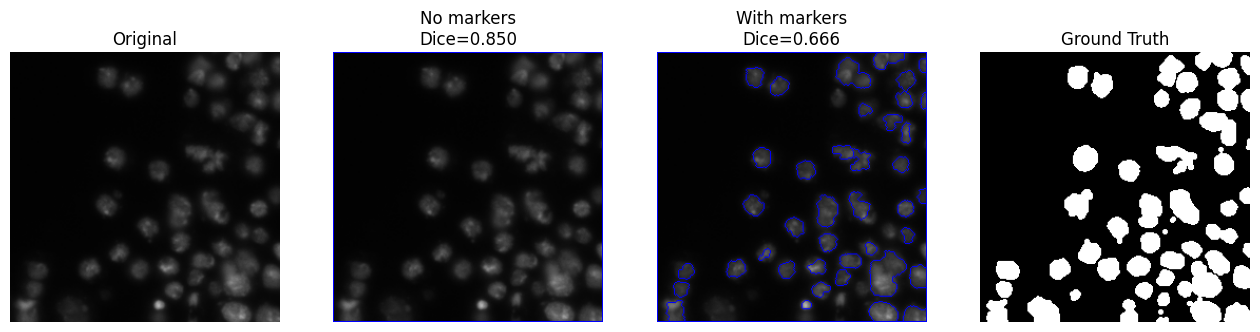

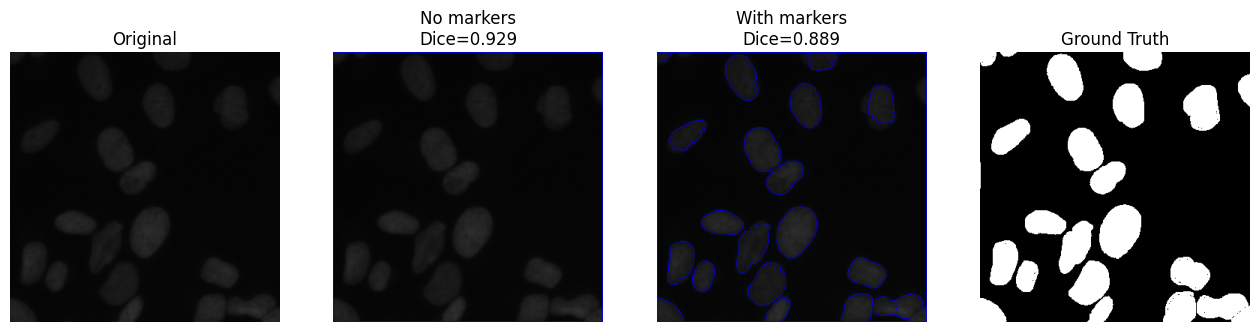

Average Dice WITHOUT markers: 0.575918542169592
Average Dice WITH markers: 0.5117667859484678


In [14]:
folders=os.listdir(DATASET_PATH)[:8]

scores_no=[]
scores_yes=[]

for f in folders:

    img,gt=load_sample(os.path.join(DATASET_PATH,f))

    res_no,pred_no=watershed_without_markers(img)
    res_yes,pred_yes=watershed_with_markers(img)

    d1=dice(pred_no,gt)
    d2=dice(pred_yes,gt)

    scores_no.append(d1)
    scores_yes.append(d2)

    plt.figure(figsize=(16,4))

    plt.subplot(1,4,1)
    plt.title("Original")
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB)); plt.axis('off')

    plt.subplot(1,4,2)
    plt.title(f"No markers\nDice={d1:.3f}")
    plt.imshow(cv2.cvtColor(res_no,cv2.COLOR_BGR2RGB)); plt.axis('off')

    plt.subplot(1,4,3)
    plt.title(f"With markers\nDice={d2:.3f}")
    plt.imshow(cv2.cvtColor(res_yes,cv2.COLOR_BGR2RGB)); plt.axis('off')

    plt.subplot(1,4,4)
    plt.title("Ground Truth")
    plt.imshow(gt,cmap='gray'); plt.axis('off')

    plt.show()

print("Average Dice WITHOUT markers:",np.mean(scores_no))
print("Average Dice WITH markers:",np.mean(scores_yes))

### Conclusion

The basic watershed method achieved a higher Dice score (0.576) than the marker-controlled watershed (0.512) on this dataset. This suggests that the chosen markers were not optimal and caused some nuclei to be missed. While marker-controlled watershed helps reduce over-segmentation, its performance depends heavily on accurate marker selection. Proper tuning of marker extraction can improve the results.